In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [4]:
!git clone https://github.com/DavidGoing/PHYS3151-Machine-Learning-in-Physics-2024

Cloning into 'PHYS3151-Machine-Learning-in-Physics-2024'...
remote: Enumerating objects: 808, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 808 (delta 8), reused 2 (delta 2), pack-reused 791
Receiving objects: 100% (808/808), 38.46 MiB | 27.89 MiB/s, done.
Resolving deltas: 100% (446/446), done.


Q1(a)

In [5]:
ising_conf=pd.read_csv('/content/PHYS3151-Machine-Learning-in-Physics-2024/feedforward-neural-network/Ising/Ising_conf.csv',header=None)
ising_temp=pd.read_csv('/content/PHYS3151-Machine-Learning-in-Physics-2024/feedforward-neural-network/Ising/Ising_temp.csv',header=None)
print(ising_conf.shape)
print(ising_temp.shape)
X=ising_conf.to_numpy()
T=ising_temp.to_numpy().reshape(6000)
print(X.shape)
print(T.shape)


(6000, 100)
(6000, 1)
(6000, 100)
(6000,)


In [6]:
mean_=np.sum(X,axis=0)/len(X)
print(mean_.shape)
mean,ones=np.meshgrid(mean_,np.ones(6000))
print(mean.shape)
print(mean)

sd_=np.std(X,axis=0)
sd,ones=np.meshgrid(sd_,np.ones(6000))
print(sd.shape)
print(sd)

sX=(X-mean)/sd #as required in q1a
print(sX.shape)
print(sX)




(100,)
(6000, 100)
[[-0.181      -0.17666667 -0.18766667 ... -0.18666667 -0.191
  -0.18733333]
 [-0.181      -0.17666667 -0.18766667 ... -0.18666667 -0.191
  -0.18733333]
 [-0.181      -0.17666667 -0.18766667 ... -0.18666667 -0.191
  -0.18733333]
 ...
 [-0.181      -0.17666667 -0.18766667 ... -0.18666667 -0.191
  -0.18733333]
 [-0.181      -0.17666667 -0.18766667 ... -0.18666667 -0.191
  -0.18733333]
 [-0.181      -0.17666667 -0.18766667 ... -0.18666667 -0.191
  -0.18733333]]
(6000, 100)
[[0.9834831  0.98427074 0.98223277 ... 0.98242331 0.98159004 0.9822964 ]
 [0.9834831  0.98427074 0.98223277 ... 0.98242331 0.98159004 0.9822964 ]
 [0.9834831  0.98427074 0.98223277 ... 0.98242331 0.98159004 0.9822964 ]
 ...
 [0.9834831  0.98427074 0.98223277 ... 0.98242331 0.98159004 0.9822964 ]
 [0.9834831  0.98427074 0.98223277 ... 0.98242331 0.98159004 0.9822964 ]
 [0.9834831  0.98427074 0.98223277 ... 0.98242331 0.98159004 0.9822964 ]]
(6000, 100)
[[ 1.20083406  1.19547053 -0.82702731 ... -0.827884

question (1b)

In [7]:
Y=np.array([int(i<2.269) for i in T])
print(Y.shape)
print(Y)

(6000,)
[0 0 0 ... 1 1 1]


Question (2a) and 2(b)

In [8]:
def activation(weights,inputs):
  z=np.sum(np.array(weights[1:])*np.array(inputs))+weights[0]
  activation=1/(1+np.exp(-z))
  return activation
def sig_derivative(activation):
  return activation*(np.ones(len(activation))-activation)

In [9]:
class Network(object):
  def __init__(self,n_inputs,n_layers,n_neurons_in_layer,n_outputs):
    #n_neurons_in_layer accepts both int and list output
    #for lists, the no. of neurons in each layer could be specified
    self.n_inputs=n_inputs
    self.n_layers=n_layers
    self.n_neurons_in_layer=n_neurons_in_layer
    self.n_outputs=n_outputs #1 if it is int (for a sample)
    if not(type(n_neurons_in_layer)!=int or type(n_neurons_in_layer)!=list):
      print('ERROR!')
    else:
      if type(n_neurons_in_layer)==int:
        n_neurons_in_layer=[n_neurons_in_layer for i in range(self.n_layers)]
      self.n_neurons=[n_inputs]
      self.n_neurons.extend(n_neurons_in_layer)
      self.n_neurons.append(n_outputs)
      self.weights=[np.random.random((self.n_neurons[i+1],self.n_neurons[i]+1)) for i in range(self.n_layers+1)] #include bias
      
  def forward_propagation(self,row):
    self.neuron_activation=[]
    output=row
    for i in range(self.n_layers+1):
      self.neuron_activation.append([activation(self.weights[i][j],output) for j in range(self.n_neurons[i+1])])
      output=self.neuron_activation[-1]
    return output
  
  def backward_propagation(self,actual,prediction_):
    self.deltas=[] #from output layer to input layer
    for i in range(self.n_layers+1):
      if i!=0:
        errors=np.dot(self.deltas[-1],self.weights[-i][:,1:]) #compared to notes, we use horizontal delta here, so the expression is like this
      else:
        errors=np.array(prediction_)-np.array(actual)
      de=errors*sig_derivative(self.neuron_activation[-i-1]) #finding lower level delta
      self.deltas.append(np.array(de))
    self.deltas=self.deltas[::-1]
    
  def update_weights(self,inputs_row,learning_rate):
    for i in range(self.n_layers+1):
      if i==0:
        an=np.array(inputs_row)
      else:
        an=np.array(self.neuron_activation[i-1])
      for j in range(self.n_neurons[i+1]):
        self.weights[i][j][0]-=learning_rate*self.deltas[i][j]
        self.weights[i][j][1:]-=learning_rate*self.deltas[i][j]*an
        
  def training(self,training_data,actual_data,train=1,learning_rate=0.05,n_epoch=1):
    #train=1: update weights by default, else not
    accurancy=[]
    cost=[]
    if self.n_outputs==1:
      actual_data=[[a] for a in actual_data]
    for e in range(n_epoch):
      for i in range(len(training_data)):
        prediction=self.forward_propagation(training_data[i])
        condition=[int(a>0.5) for a in prediction]
        accurancy.append(int(condition==actual_data[i])*100) #all predicts must agree
        cost.append(0.5*np.linalg.norm(np.array(prediction)-np.array(actual_data[i]))**2)
        if train==1:
          self.backward_propagation(actual_data[i],prediction)
          self.update_weights(training_data[i],learning_rate)
      self.accurancy=accurancy
      self.cost=cost

In [15]:
A=Network(100,1,3,1)
B=Network(100,2,3,1)

In [16]:
print(A.weights[1])
print(B.weights[1])
print(B.weights[2])

[[0.3812769  0.55901839 0.44111493 0.27188342]]
[[0.92317462 0.53032918 0.33471953 0.70440446]
 [0.55032866 0.3562642  0.77812113 0.03457482]
 [0.24728848 0.73298271 0.90826817 0.25306403]]
[[0.15076827 0.20669383 0.99820468 0.48727954]]


In [17]:
#shuffle data randomly
shuffle_i=np.arange(len(Y))
np.random.shuffle(shuffle_i)
print(shuffle_i.shape)
print(shuffle_i)
sX_sh=sX[shuffle_i]
Y_sh=Y[shuffle_i]
print(sX_sh)
print(Y_sh)

(6000,)
[4892 2617 3696 ...  665 5374 1772]
[[-0.83275453 -0.83649071 -0.82702731 ... -0.82788481 -0.82417299
  -0.82731308]
 [-0.83275453 -0.83649071 -0.82702731 ... -0.82788481 -0.82417299
  -0.82731308]
 [-0.83275453 -0.83649071 -0.82702731 ... -0.82788481 -0.82417299
  -0.82731308]
 ...
 [ 1.20083406  1.19547053  1.20914991 ... -0.82788481 -0.82417299
   1.20873224]
 [-0.83275453 -0.83649071 -0.82702731 ... -0.82788481 -0.82417299
  -0.82731308]
 [-0.83275453 -0.83649071 -0.82702731 ... -0.82788481 -0.82417299
  -0.82731308]]
[1 0 1 ... 0 1 0]


In [18]:
#create training and testing sets
sX_tr=sX_sh[:1000]
sX_te=sX_sh[1000:]
Y_tr=Y_sh[:1000]
Y_te=Y_sh[1000:]
print(sX_tr.shape)
print(sX_te.shape)
print(Y_tr.shape)
print(Y_te.shape)

(1000, 100)
(5000, 100)
(1000,)
(5000,)


In [19]:
A_acc_tr=[]
A_acc_te=[]
A_cost_tr=[]
A_cost_te=[]
epoch=np.arange(1000)
for ep in epoch:
  A.training(sX_tr,Y_tr)
  sA_acc_tr=np.sum(A.accurancy)/len(A.accurancy)
  sA_cost_tr=np.sum(A.cost)/len(A.cost)
  A.training(sX_te,Y_te,0)
  sA_acc_te=np.sum(A.accurancy)/len(A.accurancy)
  sA_cost_te=np.sum(A.cost)/len(A.cost)
  A_acc_tr.append(sA_acc_tr)
  A_acc_te.append(sA_acc_te)
  A_cost_tr.append(sA_cost_tr)
  A_cost_te.append(sA_cost_te)
  shuffle_i=np.arange(len(Y_tr))
  np.random.shuffle(shuffle_i)
  sX_tr=sX_tr[shuffle_i]
  Y_tr=Y_tr[shuffle_i]

In [21]:
B_acc_tr=[]
B_acc_te=[]
B_cost_tr=[]
B_cost_te=[]
epoch=np.arange(1000)
for ep in epoch:
  B.training(sX_tr,Y_tr)
  sB_acc_tr=np.sum(B.accurancy)/len(B.accurancy)
  sB_cost_tr=np.sum(B.cost)/len(B.cost)
  B.training(sX_te,Y_te,0)
  sB_acc_te=np.sum(B.accurancy)/len(B.accurancy)
  sB_cost_te=np.sum(B.cost)/len(B.cost)
  B_acc_tr.append(sB_acc_tr)
  B_acc_te.append(sB_acc_te)
  B_cost_tr.append(sB_cost_tr)
  B_cost_te.append(sB_cost_te)
  shuffle_i=np.arange(len(Y_tr))
  np.random.shuffle(shuffle_i)
  sX_tr=sX_tr[shuffle_i]
  Y_tr=Y_tr[shuffle_i]

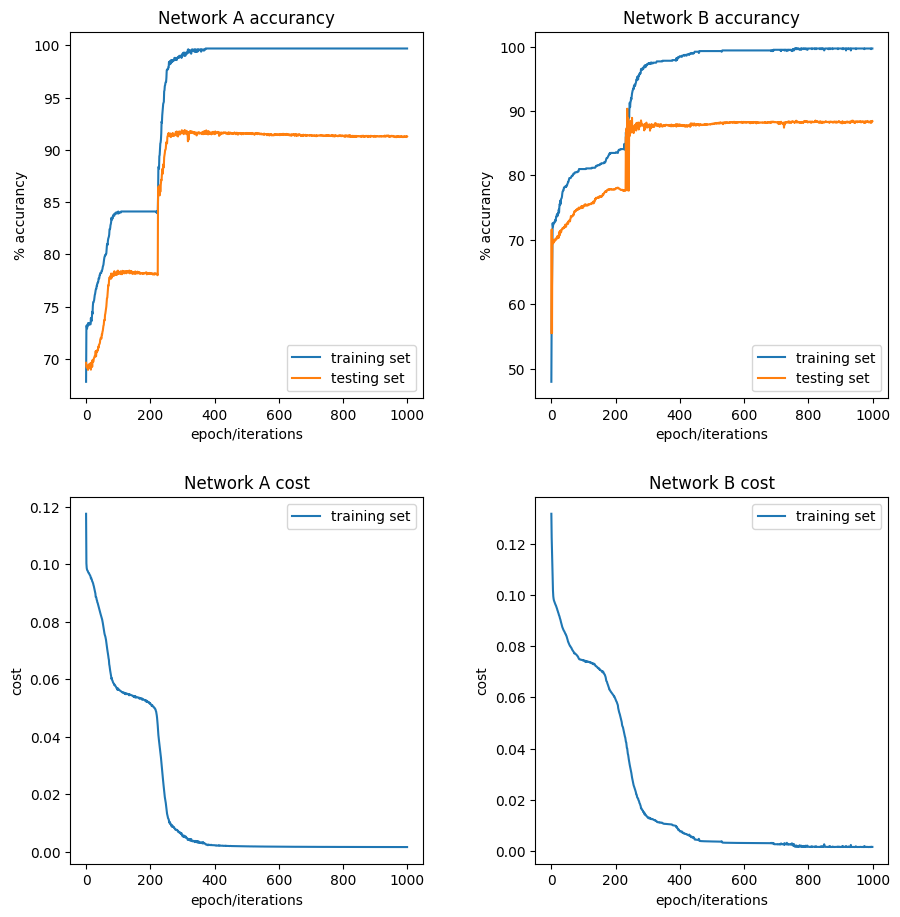

In [22]:
fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(10,10))
fig.tight_layout(pad=5)
a_acc=ax[0,0]
b_acc=ax[0,1]
a_cost=ax[1,0]
b_cost=ax[1,1]
a_acc.plot(epoch,A_acc_tr,label='training set')
a_acc.plot(epoch,A_acc_te,label='testing set')
b_acc.plot(epoch,B_acc_tr,label='training set')
b_acc.plot(epoch,B_acc_te,label='testing set')
a_cost.plot(epoch,A_cost_tr,label='training set')

b_cost.plot(epoch,B_cost_tr,label='training set')

a_acc.set_title('Network A accurancy')
b_acc.set_title('Network B accurancy')
a_cost.set_title('Network A cost')
b_cost.set_title('Network B cost')
a_acc.set_xlabel('epoch/iterations')
b_acc.set_xlabel('epoch/iterations')
a_cost.set_xlabel('epoch/iterations')
b_cost.set_xlabel('epoch/iterations')
a_acc.set_ylabel('% accurancy')
b_acc.set_ylabel('% accurancy')
a_cost.set_ylabel('cost')
b_cost.set_ylabel('cost')
a_acc.legend()
b_acc.legend()
a_cost.legend()
b_cost.legend()
plt.show()

Q4

In [23]:
a=np.squeeze([A.forward_propagation(sX[i]) for i in range(6000)])
b=np.squeeze([B.forward_propagation(sX[i]) for i in range(6000)])
t_i=np.argsort(T)
a_=a[t_i]
b_=b[t_i]
t_=T[t_i]

In [24]:
print(a_)
print(len(a_))
print(b_)
print(len(b_))

[0.99098873 0.99098873 0.99098873 ... 0.00264915 0.0027453  0.0089661 ]
6000
[0.99177339 0.99177339 0.99177339 ... 0.0259509  0.00278732 0.007533  ]
6000


In [25]:
t=np.unique(t_)
counts=[np.sum([int(t[i]==t_[j]) for j in range(len(t_))]) for i in range(len(t))]
cutoff=np.hstack(([0],[np.sum(counts[0:i+1]) for i in range(len(counts))]))
a_mean=[np.sum(a_[cutoff[i]:cutoff[i+1]])/(cutoff[i+1]-cutoff[i]) for i in range(len(t))]
b_mean=[np.sum(b_[cutoff[i]:cutoff[i+1]])/(cutoff[i+1]-cutoff[i]) for i in range(len(t))]

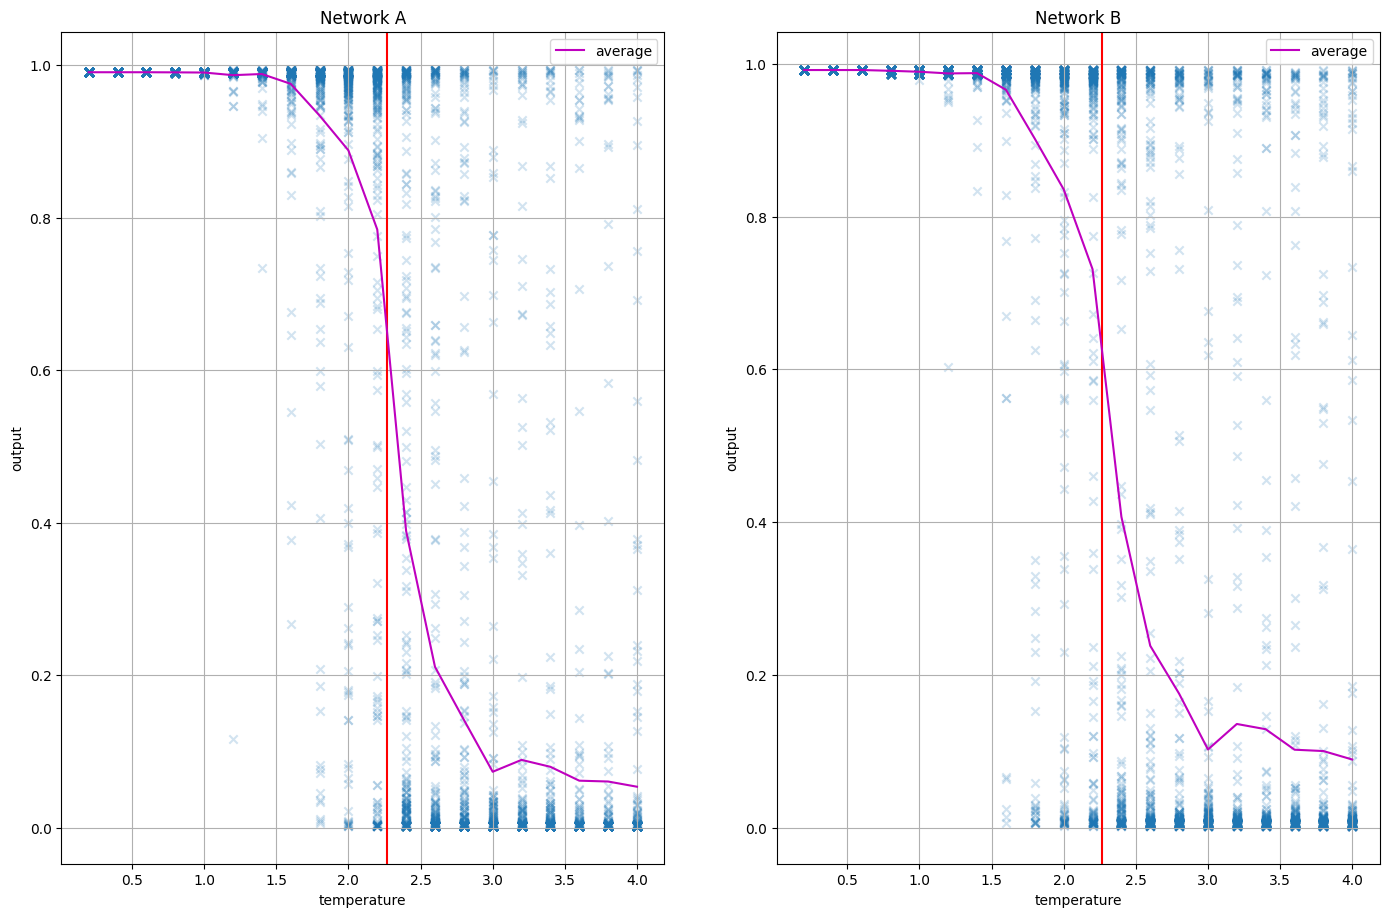

In [41]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,10))
fig.tight_layout(pad=5)
aa=ax[0]
bb=ax[1]
aa.axvline(x=2.269, color='r')
bb.axvline(x=2.269, color='r')
aa.scatter(t_,a_,marker='x',alpha=0.2)
bb.scatter(t_,b_,marker='x',alpha=0.2)
aa.plot(t,a_mean,c='m',label='average')

bb.plot(t,b_mean,c='m',label='average')
aa.set_title('Network A')
bb.set_title('Network B')
aa.set_xlabel('temperature')
bb.set_xlabel('temperature')
aa.set_ylabel('output')
bb.set_ylabel('output')
aa.grid()
bb.grid()
aa.legend()
bb.legend()
plt.show()

Question 5

Accuracy: the testing set of Network B converage faster or similar to the training set.

Cost: While, the training set of Network A attain the lower epoch when the cost is reaching zero.

$\Rightarrow$, cannot determine the which Network is better solely by the accuracy and cost.

For the output against temperature,
We know that the theoretical value for the phase transition point is at T = 2.269
The comparsion of efficiency of Network A and Network B should base on the theoretical analysis.

We observe that the slope of Network A is steeper than the Network B. 

We conclude that the efficiency of A is better.

